In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from __future__ import print_function
from __future__ import absolute_import

import itertools
import warnings
import pickle
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.contrib.layers import flatten
import keras
import keras.backend as K
from keras import callbacks
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.utils.visualize_util import plot
from keras.layers import Activation, AveragePooling2D, BatchNormalization, Convolution2D, Dense, Dropout, Flatten
from keras.layers import Dense, Input, Conv2D, SeparableConvolution2D, MaxPooling2D, GlobalAveragePooling2D, Lambda, merge
from keras.models import model_from_json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid", {'axes.grid' : False})

#device_lib.list_local_devices()

Using TensorFlow backend.


In [2]:
IMG_DIR = os.path.join("training_data", "IMG_udacity/")
DRIVE_LOG = os.path.join("training_data", "driving_log.csv")
INPUT_SHAPE = (66, 200, 3)
TEST_SIZE = 0.15

EPOCHS = 15
BATCH_SIZE = 32
L_RATE = 0.008
DROPOUT_P = 0.5
MODEL_NAME = 'nv_xception_model.json'
MODEL_WEIGHT_NAME = 'nv_xception_model.h5'
MODEL_GRAPH_NAME = 'nv_xception_model.png'
LOAD_WEIGHTS = False

In [3]:
def preprocess_input(img):
    '''Corp and resize images'''
    img = cv2.resize(img[60:140, 40:280], (200, 66))

    return np.array(img, dtype="uint8")


def class_indices(input_array):
    '''Return a list of indices for each class (modified from https://goo.gl/abAOe6)'''

    idx_sort = np.argsort(input_array)
    input_array_sorted = input_array[idx_sort]
    vals, idx_start, count = np.unique(input_array_sorted, return_counts=True, return_index=True)

    return np.split(idx_sort, idx_start[1:])


def augment_image_single(img, ang_range=5, shear_range=0, trans_range=10):
    '''Return an img with random rotation, translation and shear

    Modified from Yivek Yadav's approach using OpenCV (https://goo.gl/ttRKL0)
    '''

    img_aug = np.copy(img)
    height, width, ch = img_aug.shape

    # rotation
    if ang_range != 0:
        ang_rot = np.random.uniform(ang_range) - ang_range / 2
        rot_M = cv2.getRotationMatrix2D((width / 2, height / 2), ang_rot, 1)
        img_aug = cv2.warpAffine(img_aug, rot_M, (width, height))

    # translation
    if trans_range != 0:
        tr_x, tr_y = trans_range * np.random.uniform(size=(2, 1)) - trans_range / 2
        trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
        img_aug = cv2.warpAffine(img_aug, trans_M, (width, height))

    # shear
    if shear_range != 0:
        pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
        pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
        pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2
        pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
        shear_M = cv2.getAffineTransform(pts1, pts2)
        img_aug = cv2.warpAffine(img_aug, shear_M, (width, height))
    
    return img_aug


def augment_images(X_data, y_data, multiplier=1.5, y_bins=None):
    ''' Return an augmented image dataset (HLS color space) with same number of samples in each category / bin

    '''

    X_data_augs = [*X_data]
    y_data_augs = [*y_data]
    
    print("Original data set {}".format(np.array(X_data_augs).shape))
    
    if y_bins is None:
        bin_indices_list = bin_indices(y_data)
        bin_labels, bin_counts = np.unique(y_data, return_counts=True)
    else:
        y_data_bined = np.digitize(y_data, bins=y_bins)
        bin_indices_list = class_indices(y_data_bined)
        bin_labels, bin_counts = np.unique(y_data_bined, return_counts=True)
        
    n_target = np.int(multiplier * np.max(bin_counts))
    n_augs = [(n_target - bin_count) * ((n_target - bin_count) > 0) for bin_count in bin_counts]

    print("Target num of samples for each bin: {}".format(n_target))
    print("Total num of training samples: {}\n".format(len(y_data) + np.sum(n_augs)))
    for bin_label, n_aug, bin_indices_data in zip(bin_labels, n_augs, bin_indices_list):

        print("Augmenting bin: {:2} with {:4} samples".format(bin_label, n_aug))
        for idx, bin_idx in enumerate(np.random.choice(bin_indices_data, size=n_aug)):
            x_aug = augment_image_single(X_data[bin_idx])
            y_aug = y_data[bin_idx]

            # randomly flip the image horizontally
            flip = np.random.choice([True, False])
            if flip:
                x_aug = cv2.flip(x_aug, 1)
                y_aug = -y_aug
            
            X_data_augs.append(x_aug)
            y_data_augs.append(y_aug)
    
    # standardize inputs and conver to HLS color space
    # Lambda layer in keras has serialization problems across machines
    X_data_augs = [cv2.cvtColor(x_aug, cv2.COLOR_RGB2HLS).astype("float32")/255.0 - 0.5 for x_aug in X_data_augs]

    return np.array(X_data_augs), np.hstack(y_data_augs)

In [4]:
print("Gathering list of images from the center camera\n")
img_files_center = [IMG_DIR + img_file for img_file in sorted(os.listdir(IMG_DIR))
                    if img_file.endswith('.jpg') and img_file.startswith('center')]

print("Constructing input tensors (X_data and y_data)\n")
X_data = []

for img_file in img_files_center:
    img = mpimg.imread(img_file)
    X_data.append(preprocess_input(img))

# gather associated steering angle
df_y = pd.read_csv(DRIVE_LOG)
y_data = df_y["steering"].values

print("Finished constructing input tensors\n")

Gathering list of images from the center camera

Constructing input tensors (X_data and y_data)

Finished constructing input tensors



In [5]:
# sanity check
def sanity_check():
    df_img_files_center = df_y["center"].values

    for img_file, df_img_file in zip(img_files_center, df_img_files_center):
        assert(img_file.split('/')[2] == df_img_file.split('/')[1])
    
    print(img_file)
    print(df_img_file)
    
sanity_check()

training_data/IMG_udacity/center_2016_12_01_13_46_38_947.jpg
IMG/center_2016_12_01_13_46_38_947.jpg


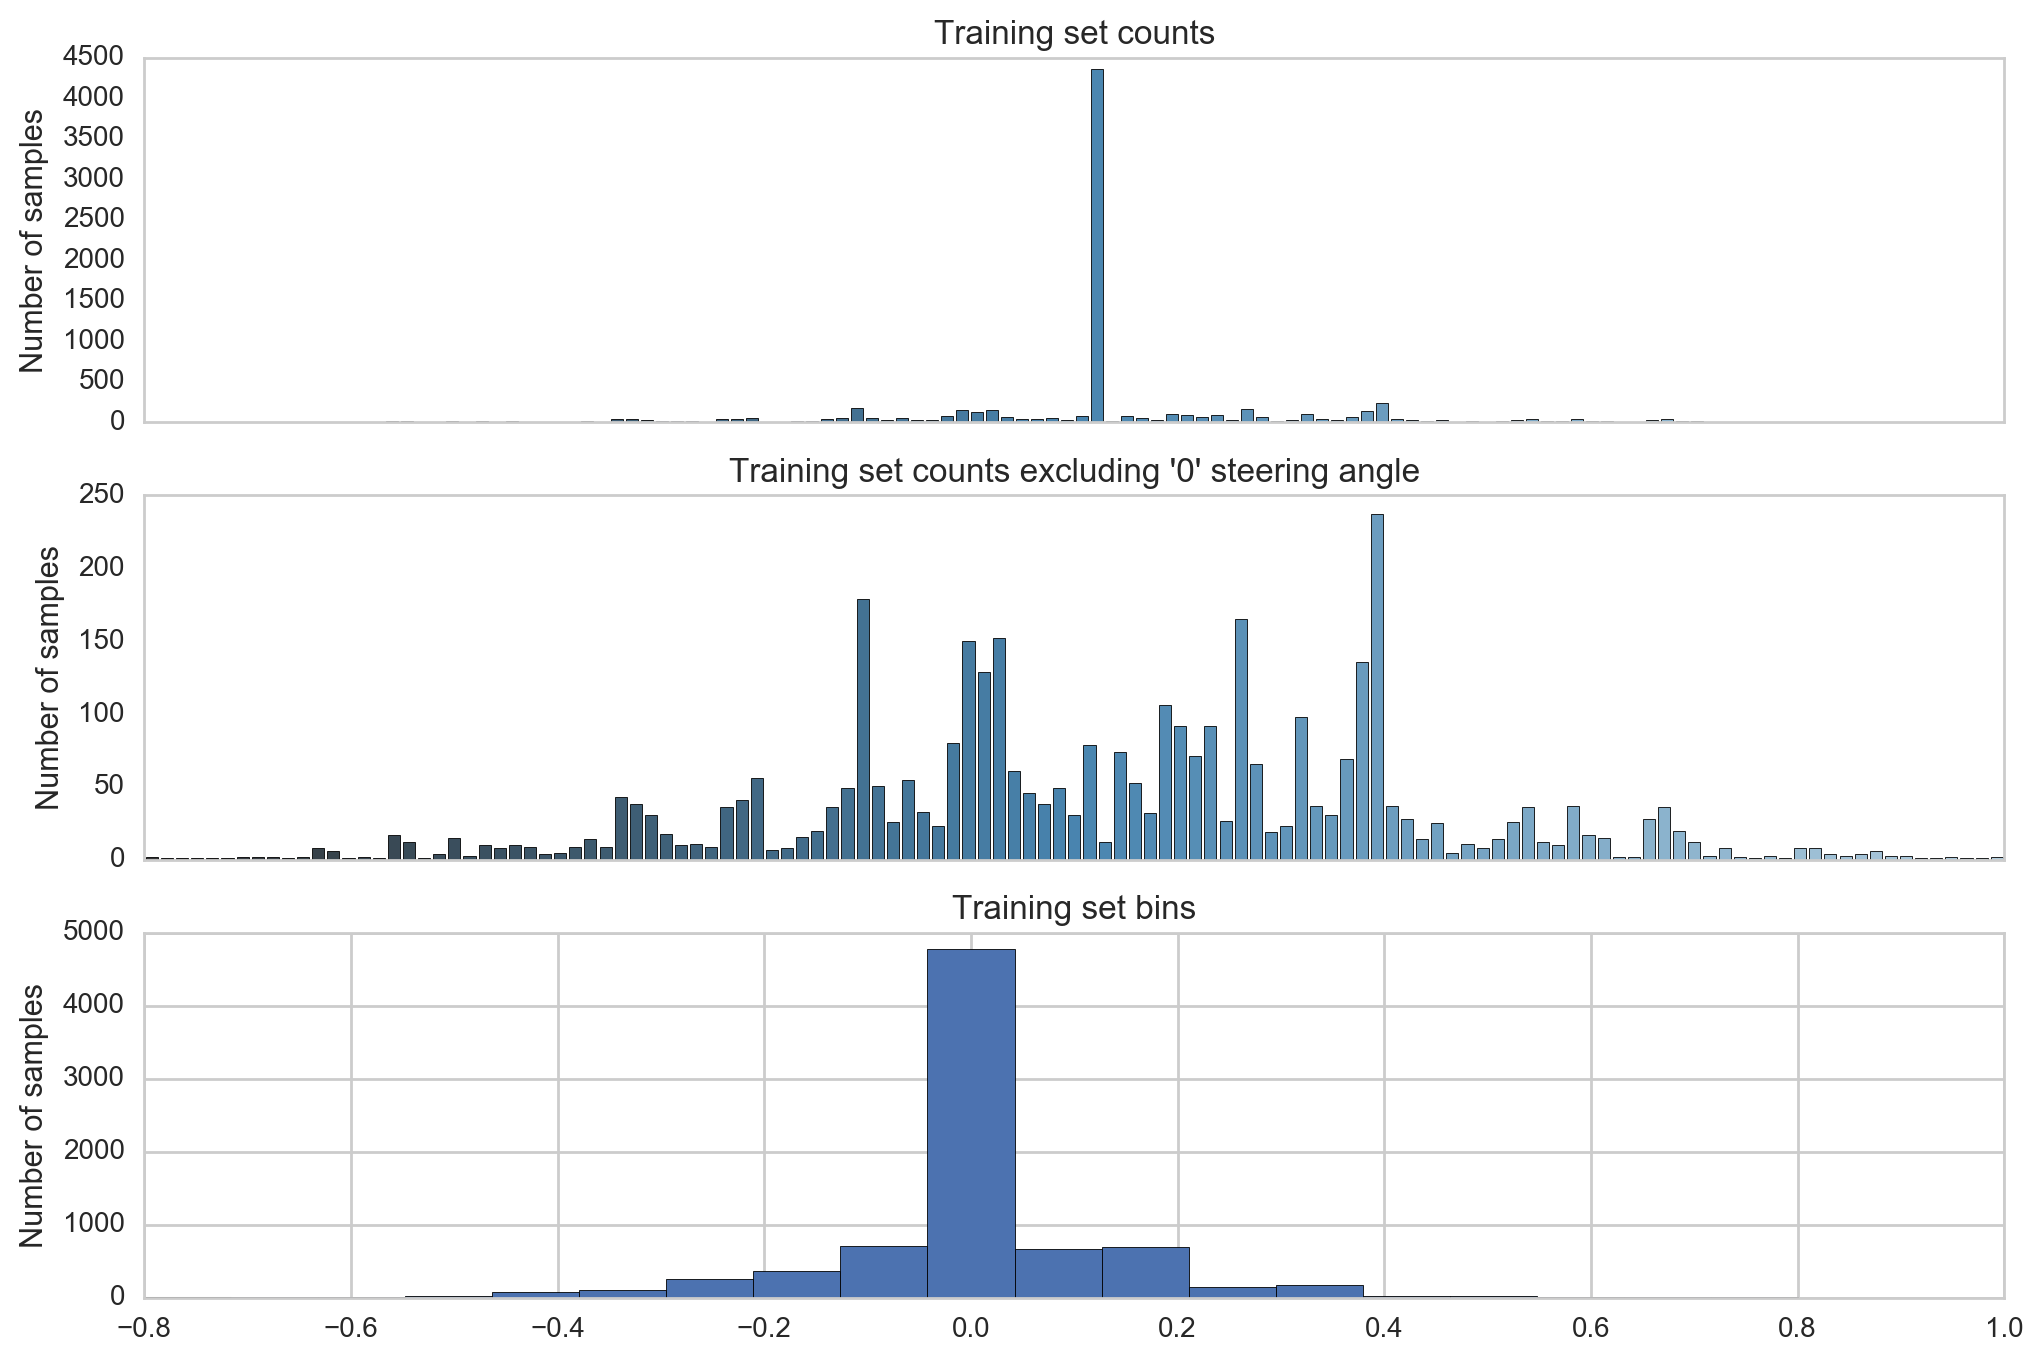

In [6]:
# Visualization of traing data revels imbalanced data 
# with most of the images paired with "0" steering angle.
# Thus data augmentation would be necessary to bring the 
# number of training samples in each bin to similear level.

fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3,1,1)
df_y_train = df_y['steering']
n_classes, n_count = np.unique(df_y_train.values, return_counts=True)
sns.barplot(n_classes, n_count, palette="Blues_d")
plt.ylabel("Number of samples")
plt.title("Training set counts")
plt.tick_params(labelbottom='off')

plt.subplot(3,1,2)
df_y_train = df_y['steering'].loc[df_y['steering']!=0]
n_classes, n_count = np.unique(df_y_train.values, return_counts=True)
sns.barplot(n_classes, n_count, palette="Blues_d")
plt.ylabel("Number of samples")
plt.title("Training set counts excluding '0' steering angle")
plt.tick_params(labelbottom='off')

plt.subplot(3,1,3)
y_bins = np.linspace(-0.8,0.8,20)
df_y['steering'].hist(bins=y_bins)
plt.ylabel("Number of samples")
plt.title("Training set bins")

In [7]:
print("Augmenting input tensors\n")
y_bins = np.linspace(-0.8, 0.8, 20)
X_train_augs, y_train_augs = augment_images(X_data, y_data, multiplier=0.5, y_bins=y_bins)
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_train_augs,
                                                                  y_train_augs,
                                                                  test_size=TEST_SIZE)

Augmenting input tensors

Original data set (8036, 66, 200, 3)
Target num of samples for each bin: 2387
Total num of training samples: 52515

Augmenting bin:  0 with 2382 samples
Augmenting bin:  1 with 2385 samples
Augmenting bin:  2 with 2385 samples
Augmenting bin:  3 with 2383 samples
Augmenting bin:  4 with 2367 samples
Augmenting bin:  5 with 2316 samples
Augmenting bin:  6 with 2284 samples
Augmenting bin:  7 with 2137 samples
Augmenting bin:  8 with 2021 samples
Augmenting bin:  9 with 1678 samples
Augmenting bin: 10 with    0 samples
Augmenting bin: 11 with 1726 samples
Augmenting bin: 12 with 1700 samples
Augmenting bin: 13 with 2240 samples
Augmenting bin: 14 with 2218 samples
Augmenting bin: 15 with 2361 samples
Augmenting bin: 16 with 2362 samples
Augmenting bin: 17 with 2380 samples
Augmenting bin: 18 with 2383 samples
Augmenting bin: 19 with 2386 samples
Augmenting bin: 20 with 2385 samples


Augmented training data shape (44637, 66, 200, 3)
Augmented validation data shape (7878, 66, 200, 3)
Original image shape (160, 320, 3)



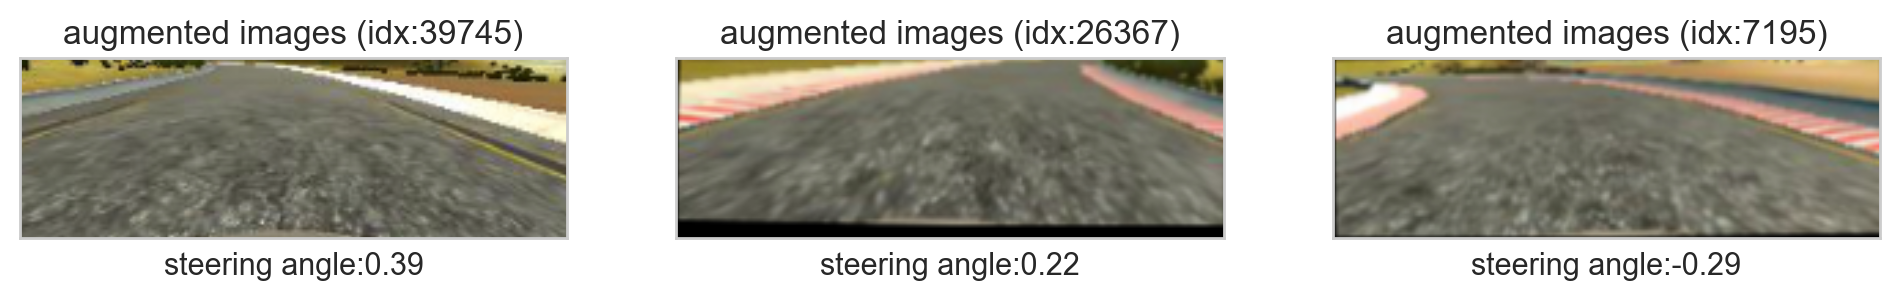

In [8]:
print("Augmented training data shape {}".format(X_train_std.shape))
print("Augmented validation data shape {}".format(X_val_std.shape))
print("Original image shape {}".format(mpimg.imread(img_files_center[0]).shape))
print()

total_plts = 3
plt.figure(figsize=(12,4))

for idx_plt, idx_img in enumerate(np.random.randint(0, len(X_train_std), size=total_plts)):
    img = (X_train_std[idx_img]+0.5)*255
    img = cv2.cvtColor(img.astype("uint8"), cv2.COLOR_HLS2RGB)
    y_label = y_train_augs[idx_img]

    plt.subplot(1,total_plts,idx_plt+1)
    plt.imshow(img)
    plt.xlabel("steering angle:{:4.2f}".format(y_label))
    plt.title("augmented images (idx:{})".format(idx_img))
    plt.tick_params(labelbottom='off', labelleft='off')

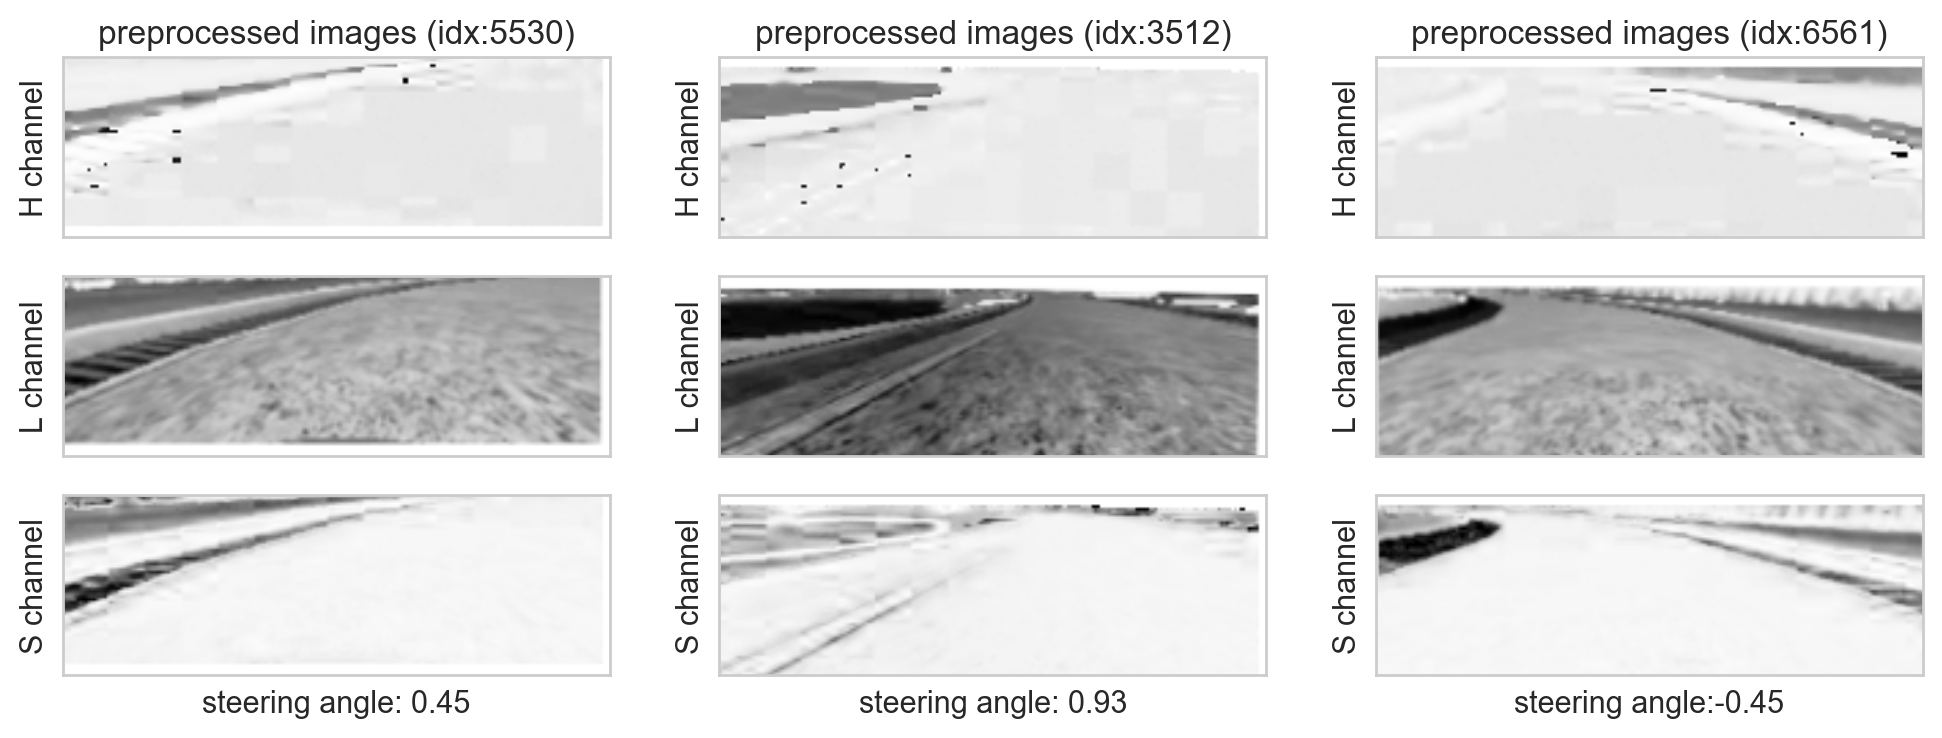

In [9]:
plt.figure(figsize=(12,4))

for idx_plt, idx_img in enumerate(np.random.randint(0, len(X_data), size=total_plts)):
    
    img = (255*(X_train_std[idx_img]+0.5)).astype("uint8")
    y_label = y_train_std[idx_img]
    
    plt.subplot(3,total_plts,idx_plt+1)
    plt.imshow(img[:,:,0])
    plt.title("preprocessed images (idx:{})".format(idx_img))
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.ylabel("H channel")

    plt.subplot(3,total_plts,idx_plt+1+total_plts)
    plt.imshow(img[:,:,1])
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.ylabel("L channel")
    
    plt.subplot(3,total_plts,idx_plt+1+total_plts*2)
    plt.imshow(img[:,:,2])
    plt.xlabel("steering angle:{:5.2f}".format(y_label))
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.ylabel("S channel")

In [11]:
def nv_xception(intputs):
    '''Return keras model

    The nv_xception model borrows the general structure from NVIDIA self-driving car paper (Bojarski et al, https://arxiv.org/abs/1604.07316)
    and replaces several convolution layers with depth-wise separable convolution layer (Chollet, https://arxiv.org/abs/1610.02357).

    The resulting model has accepts input data of shape (None, 66, 200, 3) with 5 blocks followed
    by output of shape (None, 1). The details are listed in the model summary below.
    '''

    # x = Lambda(lambda x: x / 255.0 - 0.5, name="standardize_imgs")(intputs)

    x = Convolution2D(48, 5, 5, name="block1_conv")(inputs)
    x = BatchNormalization(name="block1_bn")(x)
    x = Activation('relu', name="block1_act")(x)

    x = Convolution2D(96, 5, 5, name="block2_conv")(x)
    x = BatchNormalization(name="block2_bn")(x)
    x = Activation('relu', name="block2_act")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="block2_max_pool")(x)

    x = SeparableConvolution2D(192, 5, 5, name="block3_sepconv")(x)
    x = BatchNormalization(name="block3_bn")(x)
    x = Activation('relu', name="block3_act")(x)
    x = MaxPooling2D(pool_size=(2, 2), name="block3_max_pool")(x)

    x = SeparableConvolution2D(384, 3, 3, name="block4_sepconv")(x)
    x = BatchNormalization(name="block4_bn")(x)
    x = Activation('relu', name="block4_act")(x)

    x = SeparableConvolution2D(768, 3, 3, name="block5_sepconv")(x)
    x = BatchNormalization(name="block5_bn")(x)
    x = Activation('relu', name="block5_act")(x)

    x = GlobalAveragePooling2D(name="avg_pool")(x)

    x = Dropout(p=DROPOUT_P, name="drop_out")(x)

    outputs = Dense(1, name="steering_angle")(x)

    return outputs

In [12]:
print("Building nv_xception model\n")
inputs = Input(shape=INPUT_SHAPE, name="input_layer")
outputs = nv_xception(inputs)
model = Model(input=inputs, output=outputs)
model.compile(optimizer=RMSprop(lr=L_RATE), loss='mae', metrics=['mean_squared_error'])

if LOAD_WEIGHTS:
    model.load_weights(MODEL_WEIGHT_NAME)

with open(MODEL_NAME, 'w') as f:
    f.write(model.to_json())

model.summary()
plot(model=model, to_file=MODEL_GRAPH_NAME, show_shapes=True)

Building nv_xception model

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_layer (InputLayer)         (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
block1_conv (Convolution2D)      (None, 62, 196, 48)   3648        input_layer[0][0]                
____________________________________________________________________________________________________
block1_bn (BatchNormalization)   (None, 62, 196, 48)   192         block1_conv[0][0]                
____________________________________________________________________________________________________
block1_act (Activation)          (None, 62, 196, 48)   0           block1_bn[0][0]                  
_______________________________________________________________

In [14]:
print("Training nv_xception model\n")
cb_check_pt = callbacks.ModelCheckpoint(filepath=MODEL_WEIGHT_NAME, verbose=0, save_best_only=True)
cb_reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005)

history = model.fit(X_train_std, y_train_std,
                    validation_data=(X_val_std, y_val_std),
                    nb_epoch=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[cb_check_pt, cb_reduce_lr])

Training nv_xception model

Train on 44637 samples, validate on 7878 samples
Epoch 1/15
44637/44637 [==============================] - 176s - loss: 0.2454 - mean_squared_error: 0.1336 - val_loss: 0.2015 - val_mean_squared_error: 0.0662

In [15]:
preds = model.predict(X_val_std, batch_size=32)
df_preds = pd.DataFrame(preds)
df_preds.describe()

0
count  7878.000000
mean     -0.052782
std       0.497807
min      -1.256226
25%      -0.426134
50%      -0.021409
75%       0.305420
max       1.039100

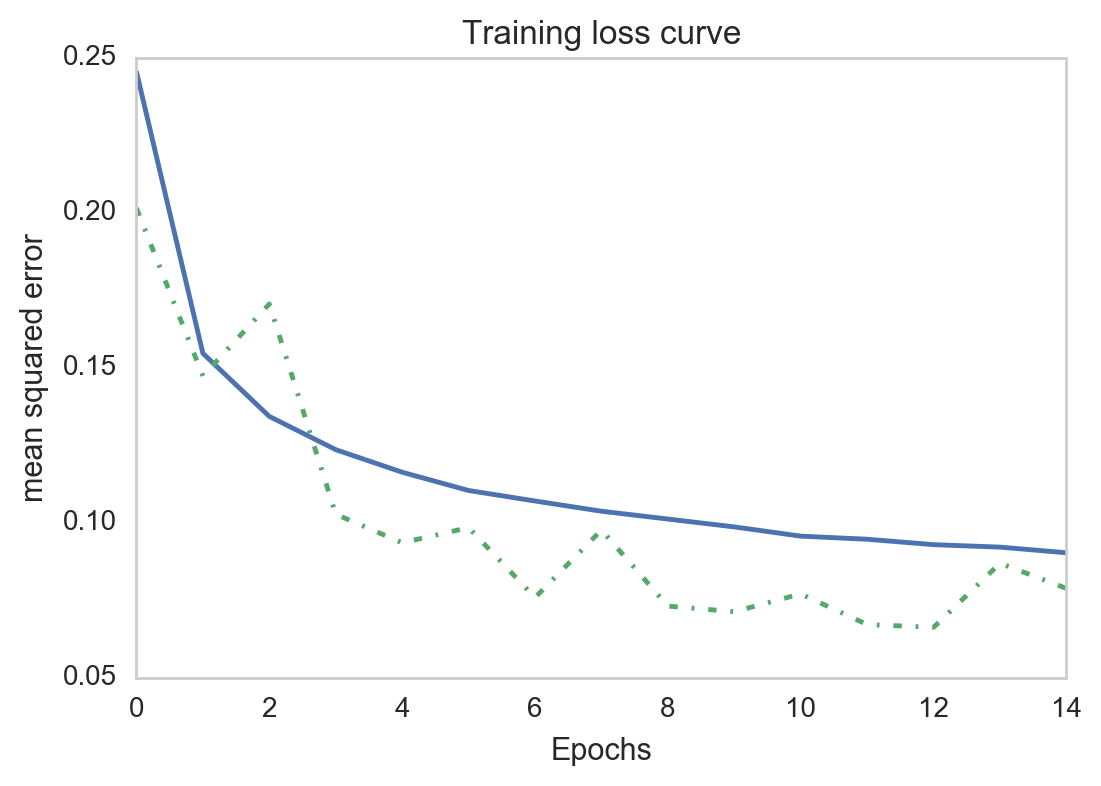

In [16]:
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

plt.plot(loss_train)
plt.plot(loss_val,"-.")
plt.xlabel("Epochs")
plt.ylabel("mean squared error")
plt.title("Training loss curve")